# **SGH x Mastercard Hackathon - May 2025**
# **Script**

*Team: **LAMP***

*Laura Hoang*, *Antoni Ballaun*, *Mateusz Kalinowski*, *Piotr Bielecki*



## 1. Exploratory Data Analysis

### 1.1. Merging all tables and basic column preprocessing
In this step, our aim is to combine all 3 datasets: **transactions.json**, **users.csv**, **merchants.csv**, in order to enrich information about the transactions with data about users and merchants. Basic column preprocessing was done as well.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter("ignore", category=UserWarning)

In [2]:
df_transactions = pd.read_json('../data/transactions.json', lines=True)
df_users = pd.read_csv('../data/users.csv')
df_merchants = pd.read_csv('../data/merchants.csv')

In [3]:
df_merged = pd.merge(df_transactions, df_users, on='user_id', how='left')
df_merged = pd.merge(df_merged, df_merchants, on='merchant_id', how='left')
df_merged = df_merged.rename(columns={'country_x': 'country_user', 'country_y': 'country_merchant'})
df = df_merged

We are transforming `location` into `latitude` and `longitude`.

In [4]:
df['latitude'] = df['location'].apply(lambda x: x['lat'])
df['longitude'] = df['location'].apply(lambda x: x['long'])
df.drop(columns=['location'], inplace=True)

Afer the initial preporcessing, we receive such dataset:

In [5]:
df.head()

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,payment_method,is_international,...,risk_score,category,country_merchant,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months,has_fraud_history,latitude,longitude
0,TX000000,2022-06-17 23:28:00,U14804,M0314,130.03,in-store,EUR,Android,debit_card,1,...,0.426675,travel,France,0.581711,3,74.97,23,1,40.057938,14.959737
1,TX000001,2022-01-04 15:39:00,U16634,M0675,132.00,online,EUR,Android,debit_card,1,...,0.729627,electronics,Germany,0.568933,2,56.92,23,0,42.059350,1.596625
2,TX000002,2022-09-09 21:58:00,U18005,M0479,8.65,online,EUR,Android,credit_card,1,...,0.393848,gaming,Denmark,0.608070,5,98.93,75,0,50.923432,21.795262
3,TX000003,2023-11-20 06:40:00,U13690,M0538,19.82,mobile,EUR,iOS,credit_card,0,...,0.393405,electronics,Portugal,0.592656,4,21.60,82,0,56.833396,-9.881566
4,TX000004,2022-04-28 08:08:00,U04642,M0128,101.92,in-store,EUR,Android,credit_card,1,...,0.524168,gaming,Spain,0.450223,4,60.61,82,0,54.042996,2.168516


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   transaction_id                  500000 non-null  object        
 1   timestamp                       500000 non-null  datetime64[ns]
 2   user_id                         500000 non-null  object        
 3   merchant_id                     500000 non-null  object        
 4   amount                          500000 non-null  float64       
 5   channel                         500000 non-null  object        
 6   currency                        500000 non-null  object        
 7   device                          500000 non-null  object        
 8   payment_method                  500000 non-null  object        
 9   is_international                500000 non-null  int64         
 10  session_length_seconds          500000 non-null  int64  

In [7]:
df.columns

Index(['transaction_id', 'timestamp', 'user_id', 'merchant_id', 'amount',
       'channel', 'currency', 'device', 'payment_method', 'is_international',
       'session_length_seconds', 'is_first_time_merchant', 'is_fraud', 'age',
       'sex', 'education', 'primary_source_of_income',
       'sum_of_monthly_installments', 'sum_of_monthly_expenses',
       'country_user', 'signup_date', 'risk_score', 'category',
       'country_merchant', 'trust_score', 'number_of_alerts_last_6_months',
       'avg_transaction_amount', 'account_age_months', 'has_fraud_history',
       'latitude', 'longitude'],
      dtype='object')

### 1.2. Kernel density estimation

**Kernel Density Estimation (KDE)** is a technique used to estimate the *probability density function* (PDF) of a continuous random variable. It is a *non-parametric method*, meaning it does not assume any underlying distribution for the data. Instead, **KDE smooths the observed data points** using a kernel function, essentially providing a gentle curve that represents the density of data points at different values.

Source: https://medium.com/@weidagang/essential-math-for-machine-learning-kernel-density-estimation-d014df073770

We will be plotting KDE for selected variables in comparison to our target:

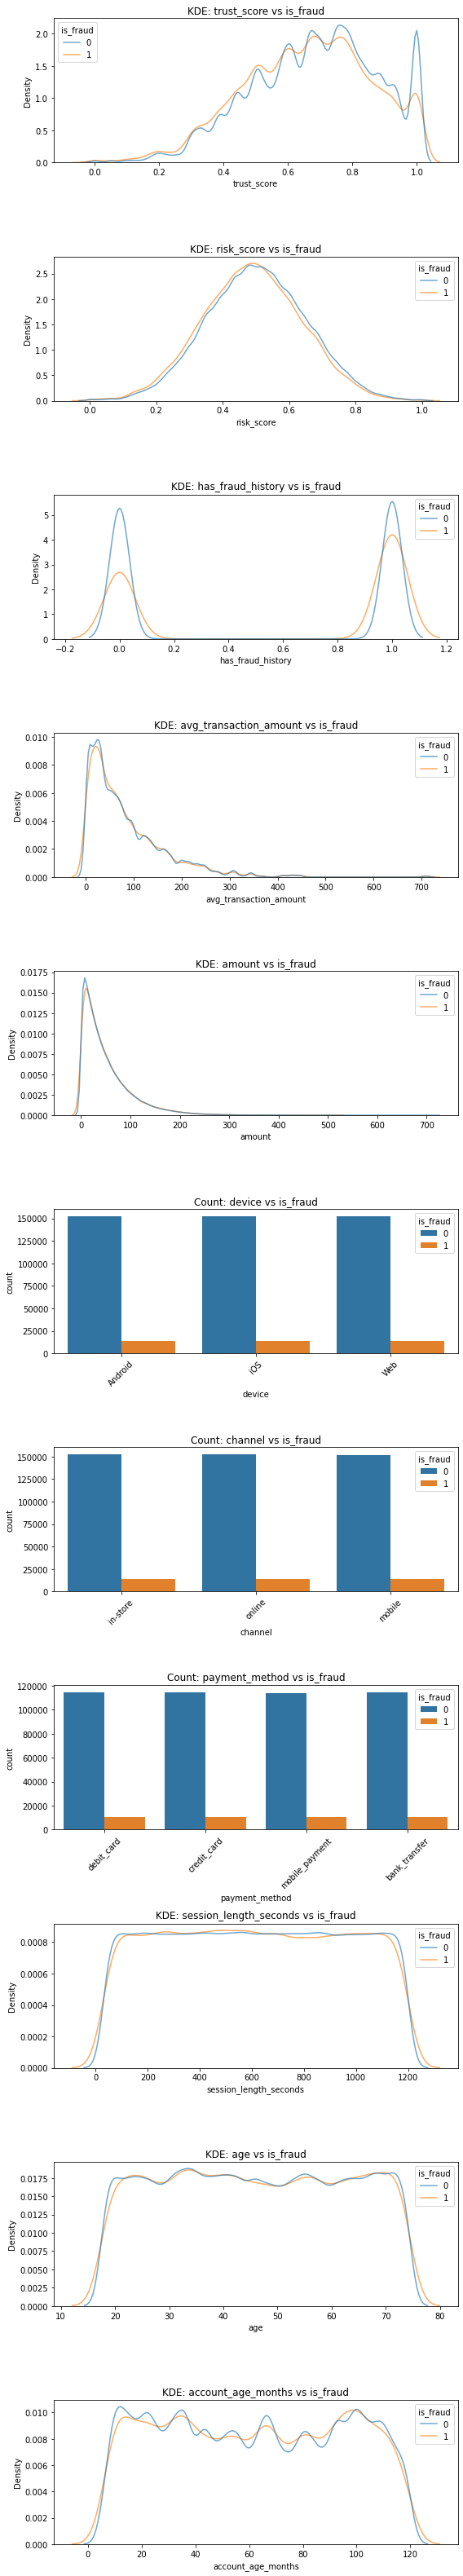

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

cols_to_plot = [
    "trust_score", 
    "risk_score",
    "has_fraud_history", 
    "avg_transaction_amount", 
    "amount", 
    "device", 
    "channel", 
    "payment_method",
    "session_length_seconds",
    "age",
    "account_age_months"
]

fig, axes = plt.subplots(nrows=len(cols_to_plot), ncols=1, figsize=(8, 4 * len(cols_to_plot)))
if len(cols_to_plot) == 1:
    axes = [axes]

for i, col in enumerate(cols_to_plot):
    if pd.api.types.is_numeric_dtype(df[col]):
        sns.kdeplot(data=df, x=col, hue="is_fraud", common_norm=False, ax=axes[i], alpha = 0.65)
        axes[i].set_title(f"KDE: {col} vs is_fraud")
    else:
        sns.countplot(data=df, x=col, hue="is_fraud",  ax=axes[i])
        axes[i].set_title(f"Count: {col} vs is_fraud")
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


The aim here is to look at the differences in distributions of features, with regards to whether the case was fraudulent or not. If the distributions are significantly different from each other, it means that the feature can distinguish well between fraud and non-fraud - at least their linear dependency - and might indicate that the variable has a strong predictive power.

Fetaures, that might have a different distribution for each of the target classes (`is_fraud` equal 1 and 0):
- `trust_score` - for non-frauds the distribution is quite "unstable" with a visible peak for `trust_score`=1.0, which means that those with a high trust score are mainly reliable.
- `risk_score` - while `trust_score` may have some distributional differences, `risk_score` does not seem to have any meaningful difference.
- `avg_transaction_amount` - similarly to trust_score, the distribution for non-frauds is a bit more unstable than for frauds.
- `session_length_seconds` - there is a slight difference in the distributions, but it is probably insignificant.
- `age` - again, for non-frauds the distribution is a bit unstable.
- `account_age_months` - here as well, the distribution for non-frauds is unstable, however in this case it is clearly visible.


### 1.3. Mutual information

So far we could only investigate linear dependencies between the features and target. Now, in order to explore further the dependency of variables, we chose to calculate their Mutual Information.

For two random variables X and Y, the **mutual information** is to measure the amount of randomness they share. It is defined as: $I(X;Y) = H(X) - H(X|Y) = H(Y) - H(Y|X)$.

![Entropy-mutual-information-relative-entropy-relation-diagram](https://upload.wikimedia.org/wikipedia/commons/d/d4/Entropy-mutual-information-relative-entropy-relation-diagram.svg)

When $I(X;Y) = H(X)$, X and Y completely determine each other.

On the other hand, if $I(X;Y) = 0$, X and Y are mutually independent.

In short terms - mutual information measures the amount of **information** that two random variables **provide about each other**.

In [11]:
df["education"] = df["education"].fillna("not defined")

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   transaction_id                  500000 non-null  object        
 1   timestamp                       500000 non-null  datetime64[ns]
 2   user_id                         500000 non-null  object        
 3   merchant_id                     500000 non-null  object        
 4   amount                          500000 non-null  float64       
 5   channel                         500000 non-null  object        
 6   currency                        500000 non-null  object        
 7   device                          500000 non-null  object        
 8   payment_method                  500000 non-null  object        
 9   is_international                500000 non-null  int64         
 10  session_length_seconds          500000 non-null  int64  

In [13]:
from sklearn.metrics import mutual_info_score

for col in df.columns:
    if col != "is_fraud":
        mi = mutual_info_score(df[col], df["is_fraud"])
        print(f"MI for {col} and is_fraud: {mi: .2f}")

MI for transaction_id and is_fraud:  0.29
MI for timestamp and is_fraud:  0.25
MI for user_id and is_fraud:  0.02
MI for merchant_id and is_fraud:  0.00
MI for amount and is_fraud:  0.02
MI for channel and is_fraud:  0.00
MI for currency and is_fraud:  0.00
MI for device and is_fraud:  0.00
MI for payment_method and is_fraud:  0.00
MI for is_international and is_fraud:  0.00
MI for session_length_seconds and is_fraud:  0.00
MI for is_first_time_merchant and is_fraud:  0.00
MI for age and is_fraud:  0.00
MI for sex and is_fraud:  0.00
MI for education and is_fraud:  0.00
MI for primary_source_of_income and is_fraud:  0.00
MI for sum_of_monthly_installments and is_fraud:  0.02
MI for sum_of_monthly_expenses and is_fraud:  0.02
MI for country_user and is_fraud:  0.00
MI for signup_date and is_fraud:  0.00
MI for risk_score and is_fraud:  0.02
MI for category and is_fraud:  0.00
MI for country_merchant and is_fraud:  0.00
MI for trust_score and is_fraud:  0.00
MI for number_of_alerts_last_

1. High MI for `transaction_id` – Red Flag
- `transaction_id` is just a unique identifier. It should have no intrinsic correlation with fraud. Does not provide predictive power.

2. High MI for `timestamp` – Potentially Valid
- If fraud happens in bursts or time windows, timestamp may carry real signal.

- But it also can cause leakage if not carefully handled (e.g., test set includes future timestamps).

- We should use this with caution: only allow engineered features from past timestamps.

3. High MI for `latitude` and `longitude` – Likely Real
- Geography often plays a key role in fraud detection.

- This could be valid signal — or a proxy for other unmodeled factors (e.g., country risk).

In [ ]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

X = df.drop(columns=["is_fraud", "timestamp", "user_id", "merchant_id", "transaction_id"])
y = df["is_fraud"]

for col in X.select_dtypes(include=["object", "category"]).columns:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

X.fillna(-999, inplace=True)

mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

mi_df = pd.DataFrame({"Feature": X.columns, "Mutual_Information": mi_scores})
mi_df = mi_df.sort_values(by="Mutual_Information", ascending=False)

print(mi_df)

                           Feature  Mutual_Information
24               has_fraud_history            0.071570
8           is_first_time_merchant            0.069504
6                 is_international            0.068017
10                             sex            0.038148
4                           device            0.037959
2                          channel            0.037596
5                   payment_method            0.022351
11                       education            0.021646
12        primary_source_of_income            0.016701
21  number_of_alerts_last_6_months            0.015580
18                        category            0.012357
19                country_merchant            0.007418
15                    country_user            0.007118
20                     trust_score            0.002532
22          avg_transaction_amount            0.002337
9                              age            0.001626
23              account_age_months            0.001254
13     sum

| Feature                  | MI Score   | Interpretation                                                             |
|--------------------------|------------|----------------------------------------------------------------------------|
| `has_fraud_history`      | 0.071      | Past fraud involvement is clearly informative.                            |
| `is_first_time_merchant` | 0.069      | Fraud is often associated with first-time interactions.                   |
| `is_international`       | 0.068      | Cross-border transactions can be riskier and more suspicious.             |
| `sex`, `device`, `channel` | ~0.037–0.038 | User/device traits offer some weak signal, possibly behavior-linked.   |

### 1.3 Attack Bursts on Merchant Countries
- Although it cannot really be used to predict attacks, as this is would lead to data leakage
- provides useful insights into how the fradulent transactions are distributed geo-temporally  
##### with a 1h rolling window on fraud rate and 2.5 z-score threshold we conclude, that over `20%` of all attacks occur in the span of just over `5%` of all the time in the dataset.

This function identifies and evaluates periods of elevated fraud activity ("attacks") over time within each `country_merchant` region.

**How it works:**
1. **Rolling Fraud Rate Calculation:**  
   - For each `country_merchant`, compute rolling fraud rates using a specified time window (here `1h`).
   - Track how fraud rate changes over time.

2. **Anomaly Detection with Z-Scores:**  
   - Calculate the z-score of the rolling fraud rate to detect sudden surges.
   - Mark timepoints as the start of an attack if:
     - z-score is high (`> zscore_threshold`)
     - fraud rate is increasing.
   - Mark stop when the z-score drops and the rate decreases.

3. **Labeling Attack Periods:**  
   - Walk through the data per region, marking periods between "start" and "stop" as `in_attack`.

4. **Evaluation Metrics:**
   - **Coverage:** What % of all frauds happened during attack periods?
   - **Precision:** What % of transactions during attacks were actual frauds?
   - **Average attack time (%):** On average, what % of time per region is spent in an "attack"?

**Purpose:**  
This logic helps detect fraud *waves* or *bursts* in real time, providing interpretable fraud windows and offering insight into temporal fraud dynamics per region.m

In [36]:
import numpy as np
from scipy.stats import zscore

def evaluate_attack_detection(df, parameters):
    df_eval = df.copy()
    
    # Prepare data
    df_eval['timestamp'] = pd.to_datetime(df_eval['timestamp'])
    df_eval = df_eval.sort_values(by=['country_merchant', 'timestamp'])
    df_eval.set_index('timestamp', inplace=True)
    
    window = parameters['window']
    z_thresh = parameters['zscore_threshold']
    
    # Rolling fraud stats
    df_eval['rolling_fraud_count'] = (
        df_eval.groupby('country_merchant')['is_fraud']
        .rolling(window=window).sum().reset_index(level=0, drop=True)
    )
    
    df_eval['rolling_txn_count'] = (
        df_eval.groupby('country_merchant')['is_fraud']
        .rolling(window=window).count().reset_index(level=0, drop=True)
    )
    
    df_eval['rolling_fraud_rate'] = (
        df_eval['rolling_fraud_count'] / df_eval['rolling_txn_count']
    ).fillna(0)
    
    # z-score + rate change
    df_eval['fraud_rate_change'] = (
        df_eval.groupby('country_merchant')['rolling_fraud_rate'].diff()
    )
    
    df_eval['zscore_fraud_rate'] = (
        df_eval.groupby('country_merchant')['rolling_fraud_rate']
        .transform(lambda x: zscore(x.fillna(0)))  # zscore - (x - srednia) / odchylenie
    )
    
    # Start and stop flags
    df_eval['fraud_attack_start_flag'] = (
        (df_eval['zscore_fraud_rate'] > z_thresh) &
        (df_eval['fraud_rate_change'] > 0)
    )

    df_eval['fraud_attack_stop_flag'] = (
        (df_eval['zscore_fraud_rate'] < 1.0) &
        (df_eval['fraud_rate_change'] < 0)
    )

    # Label in_attack periods
    df_eval['in_attack'] = False
    for country in df_eval['country_merchant'].unique():
        mask = df_eval['country_merchant'] == country
        df_c = df_eval.loc[mask]
        in_attack = False
        flags = []

        for _, row in df_c.iterrows():
            if row['fraud_attack_start_flag']:
                in_attack = True
            elif row['fraud_attack_stop_flag']:
                in_attack = False
            flags.append(in_attack)
        
        df_eval.loc[mask, 'in_attack'] = flags
    
    # Stats
    total_fraud = df_eval['is_fraud'].sum()
    fraud_in_attack = df_eval[df_eval['in_attack'] & (df_eval['is_fraud'] == 1)].shape[0]
    total_in_attack = df_eval[df_eval['in_attack']].shape[0]

    coverage = 100 * fraud_in_attack / total_fraud if total_fraud else 0
    precision = 100 * fraud_in_attack / total_in_attack if total_in_attack else 0

    df_eval = df_eval.sort_index()  # ensure chronological order

    # Calculate time delta between rows
    df_eval['delta_time'] = df_eval.index.to_series().diff().fillna(pd.Timedelta(seconds=0))

    # Time spent in attack
    time_in_attack = df_eval.loc[df_eval['in_attack'], 'delta_time'].sum()

    # Total duration of dataset
    total_time = df_eval.index[-1] - df_eval.index[0]

    # Compute percentage
    attack_time_percentages = []

    for country, df_c in df_eval.groupby('country_merchant'):
        df_c = df_c.sort_index()
        df_c['delta_time'] = df_c.index.to_series().diff().fillna(pd.Timedelta(seconds=0))
        
        time_in_attack = df_c.loc[df_c['in_attack'], 'delta_time'].sum()
        total_time = df_c.index[-1] - df_c.index[0]

        if total_time.total_seconds() > 0:
            percent = 100 * time_in_attack.total_seconds() / total_time.total_seconds()
            attack_time_percentages.append(percent)

    # Final: mean percentage across all countries
    avg_attack_time_percent = np.mean(attack_time_percentages)

    return {
        'window': parameters['window'],
        'zscore_threshold': parameters['zscore_threshold'],
        'percent_of_total_fraud_caught': coverage,
        'percent_of_fraud_to_all_transactions_in_attack': precision,
        'frauds_detected': fraud_in_attack,
        'transactions_in_attack_periods': total_in_attack,
        'time_in_attacks_avg_across_countries': avg_attack_time_percent
    }


params = {'window': '4h', 'zscore_threshold': 2.5}
res = evaluate_attack_detection(df_merged, params)
pd.DataFrame(res, index=[0])

,window,zscore_threshold,percent_of_total_fraud_caught,percent_of_fraud_to_all_transactions_in_attack,frauds_detected,transactions_in_attack_periods,time_in_attacks_avg_across_countries
0,1h,2.5,21.371814,43.151631,9064,21005,5.432841


In [25]:
df2 = df

In [28]:
categorical_cols = [
    'channel', 'currency', 'device', 'payment_method', 'category',
    'country_x', 'country_y', 'sex', 'education', 'primary_source_of_income'
]

binary_cols = [
    'is_international', 'is_first_time_merchant', 'has_fraud_history'
]

numerical_cols = [
    'amount', 'session_length_seconds', 'age', 'risk_score', 'trust_score',
    'number_of_alerts_last_6_months', 'avg_transaction_amount',
    'account_age_months', 'sum_of_monthly_expenses', 'sum_of_monthly_installments'
]

In [31]:
dummies = pd.get_dummies(df2[categorical_cols], drop_first=True).astype(int)

In [33]:
df2 = df2.drop(columns=categorical_cols)
df2 = pd.concat([df2, dummies], axis=1)
df2

,transaction_id,timestamp,user_id,merchant_id,amount,is_international,session_length_seconds,is_first_time_merchant,is_fraud,age,...,sex_Male,sex_Other,education_High School,education_Master,education_PhD,primary_source_of_income_Employment,primary_source_of_income_Retirement,primary_source_of_income_Savings,primary_source_of_income_Student Aid,primary_source_of_income_Unemployment
0,TX000000,2022-06-17 23:28:00,U14804,M0314,130.03,1,145,0,0,23,...,0,0,0,0,0,0,0,1,0,0
1,TX000001,2022-01-04 15:39:00,U16634,M0675,132.00,1,32,1,0,53,...,0,0,0,0,1,0,0,0,0,0
2,TX000002,2022-09-09 21:58:00,U18005,M0479,8.65,1,604,1,0,58,...,0,0,0,0,0,0,0,0,0,0
3,TX000003,2023-11-20 06:40:00,U13690,M0538,19.82,0,1031,1,0,59,...,1,0,0,1,0,1,0,0,0,0
4,TX000004,2022-04-28 08:08:00,U04642,M0128,101.92,1,330,0,0,28,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,TX499995,2022-04-19 18:12:00,U00062,M0079,11.53,1,916,1,0,50,...,1,0,0,0,0,1,0,0,0,0
499996,TX499996,2023-06-02 06:59:00,U17320,M0760,78.01,1,527,0,0,35,...,0,0,1,0,0,1,0,0,0,0
499997,TX499997,2022-08-06 13:14:00,U07750,M0215,77.65,1,351,0,0,37,...,0,0,0,0,0,0,0,1,0,0
499998,TX499998,2023-03-20 22:00:00,U14492,M0848,221.38,1,887,0,0,22,...,1,0,1,0,0,0,0,0,1,0


In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf_points = gpd.GeoDataFrame(df_transactions.copy(), geometry=geometry, crs="EPSG:4326")

world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip")
oceans = gpd.read_file("https://naciscdn.org/naturalearth/110m/physical/ne_110m_ocean.zip")

gdf_country = gpd.sjoin(gdf_points, world[['geometry', 'NAME']], how='left', predicate='within')
gdf_country.rename(columns={'NAME': 'country'}, inplace=True)


gdf_na = gdf_country[gdf_country['country'].isna()].copy()

# So the joins work
gdf_na = gdf_na.drop(columns=[col for col in ['index_right'] if col in gdf_na.columns])
oceans = oceans.drop(columns=[col for col in ['index_right'] if col in oceans.columns])


# gdf_ocean = gpd.sjoin(gdf_na, oceans[['geometry']], how='left', predicate='within')


# gdf_country.loc[gdf_ocean.index, 'country'] = 'Ocean'


# grouped = gdf_country.groupby(['country', 'is_fraud']).size().reset_index(name='count')


# grouped['percent'] = grouped.groupby('country')['count'].transform(lambda x: 100 * x / x.sum())


# country_order = gdf_country['country'].value_counts().index.tolist()


# plt.figure(figsize=(16, 10))
# sns.barplot(data=grouped, y='country', x='percent', hue='is_fraud', palette='Set2', order=country_order)
# plt.title('Percentage of Fraudulent and Legit Transactions by Country/Ocean')
# plt.xlabel('Percentage of Transactions')
# plt.ylabel('Country / Ocean')
# plt.legend(title='Is Fraud')
# plt.tight_layout()
# plt.show()

In [37]:
df2[df2["trust_score"] == 1].sort_values(by="is_fraud")

,transaction_id,timestamp,user_id,merchant_id,amount,is_international,session_length_seconds,is_first_time_merchant,is_fraud,age,...,sex_Male,sex_Other,education_High School,education_Master,education_PhD,primary_source_of_income_Employment,primary_source_of_income_Retirement,primary_source_of_income_Savings,primary_source_of_income_Student Aid,primary_source_of_income_Unemployment
499968,TX499968,2023-05-23 20:36:00,U04035,M0904,1.08,1,344,0,0,30,...,0,0,0,1,0,0,0,0,0,0
499182,TX499182,2022-01-22 12:38:00,U19081,M0487,71.27,1,804,0,0,73,...,0,0,1,0,0,1,0,0,0,0
499195,TX499195,2022-09-03 19:08:00,U03238,M0444,84.47,1,553,0,0,74,...,1,0,1,0,0,0,1,0,0,0
499245,TX499245,2023-07-09 15:03:00,U03637,M0989,2.03,1,1191,0,0,67,...,0,1,1,0,0,0,0,0,1,0
499268,TX499268,2023-07-28 22:44:00,U06297,M0648,62.11,1,597,0,0,33,...,1,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454014,TX454014,2023-01-02 00:12:00,U07358,M0222,63.36,1,222,1,1,20,...,1,0,0,0,1,0,0,0,1,0
427937,TX427937,2022-07-29 01:49:00,U09573,M0989,42.21,1,631,0,1,72,...,0,0,0,0,1,0,0,0,0,0
351041,TX351041,2023-03-20 08:32:00,U09574,M0075,5.27,1,1063,0,1,28,...,0,1,0,1,0,0,0,0,1,0
371352,TX371352,2023-04-16 10:28:00,U03466,M0443,10.89,1,231,1,1,43,...,0,1,0,1,0,1,0,0,0,0


In [43]:
df3 = df2[df2["is_fraud"] == 1].sort_values(by="trust_score")
df3["trust_score"]

299907    0.0
45162     0.0
467504    0.0
409659    0.0
414938    0.0
         ... 
434823    1.0
224916    1.0
434607    1.0
55398     1.0
435350    1.0
Name: trust_score, Length: 42411, dtype: float64

In [41]:
df4 = df2[df2["is_fraud"] == 1].sort_values(by="risk_score")
df4["risk_score"]

167024    0.0
210988    0.0
426276    0.0
207446    0.0
82029     0.0
         ... 
430165    1.0
372258    1.0
51133     1.0
8734      1.0
355708    1.0
Name: risk_score, Length: 42411, dtype: float64

In [46]:
df["currency"].unique()

array(['EUR'], dtype=object)

In [9]:
df[df["risk_score"]>0.99]

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,payment_method,is_international,...,risk_score,category,country_y,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months,has_fraud_history,latitude,longitude
546,TX000546,2023-01-08 08:32:00,U12786,M0805,6.37,in-store,EUR,Web,credit_card,1,...,1.000000,electronics,Spain,0.699062,0,24.56,37,1,52.448172,37.030717
2040,TX002040,2023-03-31 03:55:00,U12786,M0487,326.79,online,EUR,iOS,credit_card,1,...,1.000000,travel,Italy,1.000000,3,25.54,14,1,64.201573,-6.659911
3403,TX003403,2023-06-12 07:18:00,U05143,M0262,66.43,online,EUR,Web,bank_transfer,1,...,1.000000,gaming,Czech Republic,0.890453,4,220.18,36,1,51.077894,14.309043
8702,TX008702,2022-03-24 05:11:00,U14919,M0874,42.39,online,EUR,iOS,mobile_payment,1,...,1.000000,gaming,Belgium,0.660602,3,68.86,10,1,37.558875,-4.920919
8734,TX008734,2023-06-28 07:55:00,U05143,M0080,11.81,online,EUR,Android,debit_card,1,...,1.000000,clothing,Finland,0.376415,1,51.49,92,0,55.015899,-9.498523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494160,TX494160,2023-04-15 02:55:00,U06411,M0791,6.88,online,EUR,Android,bank_transfer,1,...,0.994508,restaurants,Poland,0.700118,1,13.90,73,1,41.369788,5.352124
495840,TX495840,2022-05-25 10:06:00,U17019,M0403,63.11,mobile,EUR,Android,credit_card,1,...,0.995262,restaurants,Netherlands,0.662965,5,20.74,50,0,39.311348,29.552425
495993,TX495993,2023-11-03 17:36:00,U03789,M0253,81.39,mobile,EUR,Android,debit_card,1,...,0.993164,clothing,Netherlands,0.591699,2,34.09,43,0,66.730347,17.455788
498662,TX498662,2023-02-14 14:00:00,U00741,M0156,12.14,online,EUR,Android,mobile_payment,1,...,1.000000,gaming,Czech Republic,0.817576,5,70.51,109,0,66.766087,-1.244642


(array([  1699.,   8749.,  33866.,  82016., 122890., 122111.,  81502.,
         35657.,   9605.,   1905.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

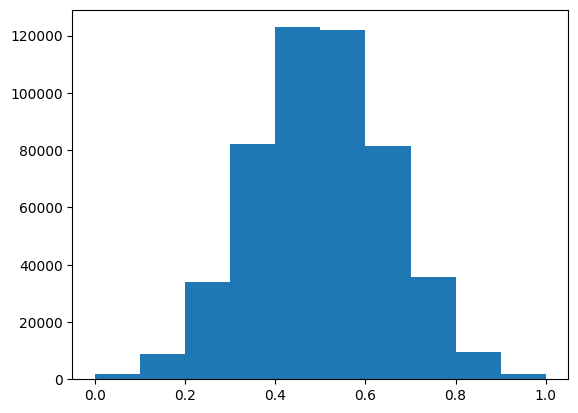

In [10]:
plt.hist(df["risk_score"])

In [11]:
df[df["user_id"] == "U00741"]

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,payment_method,is_international,...,risk_score,category,country_y,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months,has_fraud_history,latitude,longitude
61585,TX061585,2023-09-20 13:50:00,U00741,M0014,145.43,in-store,EUR,Android,credit_card,1,...,1.0,travel,Portugal,0.801802,1,70.31,43,1,53.316997,0.590333
81627,TX081627,2022-08-02 09:22:00,U00741,M0063,9.44,mobile,EUR,iOS,credit_card,1,...,1.0,restaurants,Germany,0.927067,2,44.66,64,0,42.388384,38.328245
119609,TX119609,2022-03-17 08:36:00,U00741,M0149,53.55,online,EUR,Web,mobile_payment,1,...,1.0,gaming,France,0.733931,2,26.34,21,0,52.176853,-1.912018
127817,TX127817,2022-09-28 10:37:00,U00741,M0442,15.21,mobile,EUR,Android,mobile_payment,1,...,1.0,grocery,France,0.573831,0,170.37,99,1,55.182693,-7.069286
163096,TX163096,2022-06-04 07:17:00,U00741,M0346,24.70,online,EUR,Android,bank_transfer,1,...,1.0,gaming,Finland,0.784263,3,232.41,47,1,52.289667,1.996699
177513,TX177513,2023-06-20 16:44:00,U00741,M0407,2.45,online,EUR,iOS,debit_card,1,...,1.0,travel,Portugal,0.446476,5,47.30,63,0,63.598166,25.685535
224235,TX224235,2023-11-07 05:15:00,U00741,M0865,26.95,in-store,EUR,iOS,debit_card,1,...,1.0,gaming,Germany,0.562570,4,73.07,67,0,52.021487,35.159234
227681,TX227681,2023-09-28 18:06:00,U00741,M0394,19.63,in-store,EUR,Web,debit_card,1,...,1.0,education,Portugal,0.697761,2,155.35,39,1,68.951451,-0.300000
241528,TX241528,2022-09-14 13:21:00,U00741,M0811,17.63,in-store,EUR,Web,credit_card,1,...,1.0,electronics,Spain,0.702852,0,2.80,13,1,65.698885,33.020181
304923,TX304923,2022-04-28 11:17:00,U00741,M0088,4.84,in-store,EUR,Web,debit_card,0,...,1.0,electronics,Denmark,0.496026,3,195.97,93,1,52.250201,3.499207


In [12]:
# transactions[transactions["user_id"] == "U09512"].sort_values(by="timestamp")

NameError: name 'transactions' is not defined

In [ ]:
# type(transactions.location[0])

dict

In [ ]:
# transactions.location[0]["lat"]

40.057938

<BarContainer object of 2 artists>

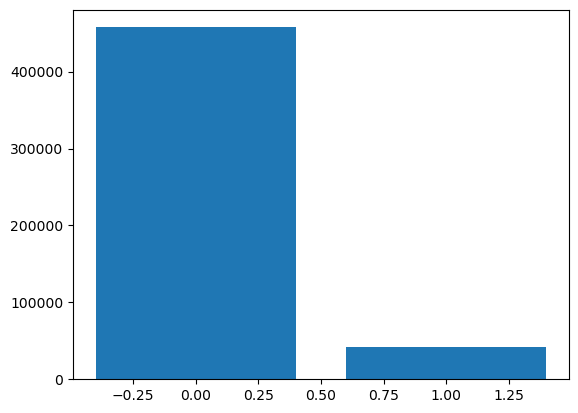

In [ ]:
# tmp = transactions["is_fraud"].value_counts()
# tmp

# plt.bar(tmp.index, tmp.values)



In [ ]:
# data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   transaction_id          500000 non-null  object        
 1   timestamp               500000 non-null  datetime64[ns]
 2   user_id                 500000 non-null  object        
 3   merchant_id             500000 non-null  object        
 4   amount                  500000 non-null  float64       
 5   channel                 500000 non-null  object        
 6   currency                500000 non-null  object        
 7   device                  500000 non-null  object        
 8   location                500000 non-null  object        
 9   payment_method          500000 non-null  object        
 10  is_international        500000 non-null  int64         
 11  session_length_seconds  500000 non-null  int64         
 12  is_first_time_merchant  500000